In [1]:
from poisson_fem import PoissonFEM
import ROM
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as lg
import time
import petsc4py
import sys
petsc4py.init(sys.argv)
from petsc4py import PETSc

In [2]:
lin_dim_rom = 16
mesh = PoissonFEM.RectangularMesh(np.ones(lin_dim_rom)/lin_dim_rom)
# mesh.plot()

In [3]:
def origin(x):
    return np.abs(x[0]) < np.finfo(float).eps and np.abs(x[1]) < np.finfo(float).eps
def essBoundaryFun(x):
    return 1.0
mesh.setEssentialBoundary(origin, essBoundaryFun)

In [4]:
def domainBoundary(x):
    # unit square
    return np.abs(x[0]) < np.finfo(float).eps or np.abs(x[1]) < np.finfo(float).eps or \
            np.abs(x[0]) > 1.0 - np.finfo(float).eps or np.abs(x[1]) > 1.0 - np.finfo(float).eps
mesh.setNaturalBoundary(domainBoundary)

In [5]:
#Define boundary flux field
def flux(x):
    a = np.array([1, 2, 3])
    q = np.array([a[0] + a[2]*x[1], a[1] + a[2]*x[0]])
    return q

In [6]:
rhs = PoissonFEM.RightHandSide(mesh)
rhs.setNaturalRHS(mesh, flux)

In [7]:
# Set up solver
ksp = PETSc.KSP().create()
ksp.setType('preonly')
pc = ksp.getPC()
pc.setType('cholesky')
ksp.setFromOptions() #???

In [8]:
funSpace = PoissonFEM.FunctionSpace(mesh)
K = PoissonFEM.StiffnessMatrix(mesh, funSpace, ksp)

In [9]:
rhs.setRhsStencil(mesh, K)

In [10]:
# Preallocate
x = PETSc.Vec().createSeq(mesh.nEq)

In [11]:
# define rom
rom = ROM.ROM(mesh, K, rhs)

In [12]:
N = 1e4

In [13]:
lmbda = PETSc.Vec().createSeq(mesh.nCells)
x = np.ones(lin_dim_rom**2)
start = time.time()
for n in range(int(N)):
#     lmbda.setValues(range(mesh.nCells), np.ones(lin_dim_rom**2))
#     lmbda.array = x
    lmbda.createWithArray(x)
    
    # solve implies stiffness/ rhs assembly and solution
    rom.solve(lmbda)
petsc_time = (time.time() - start)/N
print('PETSc time = ', petsc_time)

PETSc time =  0.00021687884330749512


In [14]:
# for scipy comparison
Kes = K.globStiffStencil.getValuesCSR()
Kes = sps.csr_matrix((Kes[2], Kes[1], Kes[0]))

In [15]:
start = time.time()
for n in range(int(N)):
    Kvecs = Kes @ lmbda.array
    K1 = sps.csr_matrix((Kvecs[K.vec_nonzero], K.indices, K.indptr))
    rhs.assemble(lmbda)   # for fair comparison
    x1 = lg.spsolve(K1, rhs.vector.array)
scipy_time = (time.time() - start)/N
print('scipy time = ', scipy_time)

scipy time =  0.0009717262029647827


In [16]:
diff = np.linalg.norm(rom.solution.array - x1)/np.linalg.norm(x1)
print('result difference = ', diff)
print('PETSc speedup = ', scipy_time/petsc_time)

result difference =  4.734148133499661e-14
PETSc speedup =  4.4805025153470135


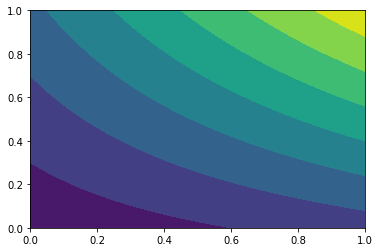

In [17]:
# plot
rom.plotSolution()

In [18]:
start = time.time()
for n in range(int(N)):    
    # solveAdjoint implies adjoint solution only. No assembly implied!!
    rom.solveAdjoint(rom.rhs.vector)
adjoint_time = (time.time() - start)/N
print('Adjoint time = ', adjoint_time)

Adjoint time =  9.410595893859863e-06


In [19]:
diff = np.linalg.norm(rom.adjointSolution.array - rom.solution.array)/\
        np.linalg.norm(rom.solution.array)   # needs to be 0 if K is symmetric
print('Adjoint difference == ', diff)

Adjoint difference ==  0.0


In [20]:
rhsAdj = PETSc.Vec().createSeq(rom.mesh.nEq)
rhsAdj.setValues(range(rom.mesh.nEq), np.arange(1.0, rom.mesh.nEq + 1))
rom.solveAdjoint(rhsAdj)

In [21]:
#assembly only
start = time.time()
for n in range(int(N)):    
    rom.stiffnessMatrix.assemble(lmbda)
assemble_time = (time.time() - start)/N
print('Assembly time = ', assemble_time)

Assembly time =  0.00012485754489898683


In [22]:
#setOperators only
start = time.time()
for n in range(int(N)):    
    rom.stiffnessMatrix.solver.setOperators(rom.stiffnessMatrix.matrix)
setOperator_time = (time.time() - start)/N
print('setOperator time = ', setOperator_time)

setOperator time =  5.234241485595703e-07


In [23]:
rom.solution.array

array([1.0625    , 1.125     , 1.1875    , 1.25      , 1.3125    ,
       1.375     , 1.4375    , 1.5       , 1.5625    , 1.625     ,
       1.6875    , 1.75      , 1.8125    , 1.875     , 1.9375    ,
       2.        , 1.125     , 1.19921875, 1.2734375 , 1.34765625,
       1.421875  , 1.49609375, 1.5703125 , 1.64453125, 1.71875   ,
       1.79296875, 1.8671875 , 1.94140625, 2.015625  , 2.08984375,
       2.1640625 , 2.23828125, 2.3125    , 1.25      , 1.3359375 ,
       1.421875  , 1.5078125 , 1.59375   , 1.6796875 , 1.765625  ,
       1.8515625 , 1.9375    , 2.0234375 , 2.109375  , 2.1953125 ,
       2.28125   , 2.3671875 , 2.453125  , 2.5390625 , 2.625     ,
       1.375     , 1.47265625, 1.5703125 , 1.66796875, 1.765625  ,
       1.86328125, 1.9609375 , 2.05859375, 2.15625   , 2.25390625,
       2.3515625 , 2.44921875, 2.546875  , 2.64453125, 2.7421875 ,
       2.83984375, 2.9375    , 1.5       , 1.609375  , 1.71875   ,
       1.828125  , 1.9375    , 2.046875  , 2.15625   , 2.26562

In [28]:
lmbda.createWithArray(np.exp(lmbda))

In [29]:
lmbda.array

array([2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828183,
       2.71828183, 2.71828183, 2.71828183, 2.71828183, 2.71828